# Music Analysis Workflow

## Setup

### Imports

In [1]:
import numpy as np
import madmom
from scipy.stats import norm
from matplotlib import pyplot as plt
import ipywidgets as widgets
from IPython.display import display
from scipy.stats import gaussian_kde
from sklearn.neighbors import KernelDensity
import json
from scipy import signal

### Audio Paths and Titles

In [2]:
with open('options.json', 'r') as file:
    data = json.load(file)

plots_dir = 'plots/'
audio_options = data['musics']

### Choose Audio

In [3]:
# Criar um dicionário onde a chave é o título da música
select_options = {music['title']: music for music in audio_options}

# Criar um dropdown para seleção
dropdown = widgets.Dropdown(
    options=select_options.keys(),
    description='Escolha uma música:',
    value=audio_options[0]['title'],
)

# Variáveis globais para armazenar a escolha atual
chosentitle = audio_options[0]['title']
chosenpath = audio_options[0]['path']

# Função para atribuir a seleção
def mostrar_valor(change):
    global chosentitle, chosenpath  # Declarar que estamos usando variáveis globais
    titulo = change['new']
    
    if titulo:
        chosen = select_options.get(titulo)
        if chosen:
            chosentitle = chosen['title']
            chosenpath = chosen['path']
# Conectar a função ao evento de mudança no dropdown
dropdown.observe(mostrar_valor, names='value')

# Exibir o dropdown
display(dropdown)

Dropdown(description='Escolha uma música:', options=('Radio Ga Ga', 'Beat - It', 'We Are The Champions'), valu…

## Transformation Functions

### Chroma processing

In [14]:
dcp = madmom.audio.chroma.DeepChromaProcessor()
chroma = dcp(chosenpath)

### SSM

In [15]:
ssm = np.dot(chroma, chroma.T)

### Histograms

In [16]:
histogram_data_ssm = ssm.flatten()
counting, limits = np.histogram(histogram_data_ssm, bins=500)

difference_cols = np.diff(ssm, axis=1)
histogram_data_diff = difference_cols.flatten()
difference_cols_counting, difference_cols_limits = np.histogram(histogram_data_diff, bins=500)

### Normal distribution Coefficients

In [17]:
mean, std_dev = np.mean(histogram_data_diff), np.std(histogram_data_diff) # Média e desvio padrão
xmin, xmax = min(histogram_data_diff), max(histogram_data_diff) # Limites do eixo x

x = np.linspace(xmin, xmax, 1000) # Eixo x
p = norm.pdf(x, mean, std_dev) # Distribuição normal

### KDE of errors column by column

In [19]:
bandwidths = [5]
for bw in bandwidths:
    integrals = []
    for col in range(1, len(ssm), 1):
        x = ssm[:, col] - ssm[:, col-1]
        kdex = gaussian_kde(x, bw_method=bw)
        integrals.append(kdex.integrate_kde(kdex))
    pltarray = np.array(integrals)
    np.save(f'kde_{bw}.npy', pltarray)
    


In [18]:
len(ssm)

2585

In [ ]:
with open(f'kde_5.npy', 'rb') as file:
    integrals = np.load(file)
xlines = [0.0,
0.162539682,
17.298866213,
55.774331065,
94.226575963,
124.249977324,
154.134058956,
162.748662131,
181.97478458,
211.951746031,
248.290975056,
267.54031746,
286.789659863,
316.74340136,
340.567074829,
343.485804988]

period = 50
xlines = [x * 10 for x in xlines]
logs_integrals = np.log2(integrals)
logs_integrals = 1 / integrals


w = signal.windows.hann(256)
# original_means = np.convolve(logs_integrals, np.ones(period)/period, mode='valid') (Média móvel)
means = np.convolve(logs_integrals, w, mode='valid')
print(means)
# means = np.ediff1d(means)

indices = np.arange(len(logs_integrals))
ma_indices = indices[:len(means)] + (period - 1) / 2



# plt.figsize=(19, 10)
plt.plot(ma_indices, means, label=f'', marker='None', color='indigo', linewidth=0.5)
# plt.plot(np.linspace(-1, len(logs_integrals), len(logs_integrals)), logs_integrals, label='integral', linewidth=0.5, alpha=0.3)
# plt.vlines(changepoints, min(means), max(means), colors='g', linestyles='dashed',  linewidth=.7)
# plt.vlines(xlines,min(means), max(means), label='Mudanças', colors='r', linestyles='dashed',  linewidth=.7)
plt.legend()
# plt.show()


FileNotFoundError: [Errno 2] No such file or directory: 'kde_5.npy'

In [17]:
import Rbeast as rb

result = rb.beast(means, season='')

# rb.plot(result)

changepoints = result.trend.cp

print(changepoints)



Model fitted:  Y =  trend + error 

INFO: To supress messages, set print_param/print_warning/print_progresss = 0 in beast() and beast_irreg()
INFO: To supress messages, Set extra.printParameter/printWarning/printProgress = 0 in beast123()
INFO: To supress all messaages, set quiet=1 in beast() and beast_irreg() or extra.quiet=1 in beast123()

#--------------------------------------------------#
#       Brief summary of Input Data                #
#--------------------------------------------------#
Data Dimension: One signal of length 3373
IsOrdered     : Yes, ordered in time
IsRegular     : Yes, evenly spaced at interval of  1 (unknown unit)
hasSeasonCmpnt: False | no periodic or seasonal component. The model Y=Trend+Error is fitted.
HasOutlierCmpt: False | If true, Y=Trend+Outlier+Error (experimental) is fitted instead of Y=Trend+Error 
Detrend       : False | If true, remove a global trend component before running BEAST & add it back after BEAST
MissingValue  : NaN  flagged as missi

In [27]:
np.save(f'plots/{chosentitle}integrals.npy', pltarray)

0.26814762801906367


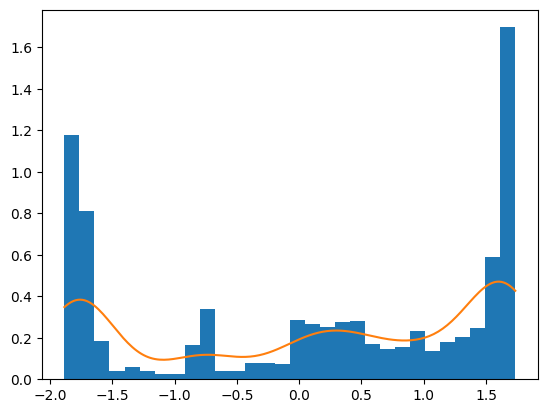

In [ ]:
# s = 0.001
# x = np.random.normal(0, s, 10000)
x = ssm[:, 490] - ssm[:, 480]
plt.hist(x, density=True, bins=30)

kdex = gaussian_kde(x)
plt.plot(np.linspace(x.min(), x.max(), 200),
         kdex(np.linspace(x.min(), x.max(), 200)), label='integral do erro x')
print(kdex.integrate_kde(kdex))

## Ploting Functions

### Plot Chroma

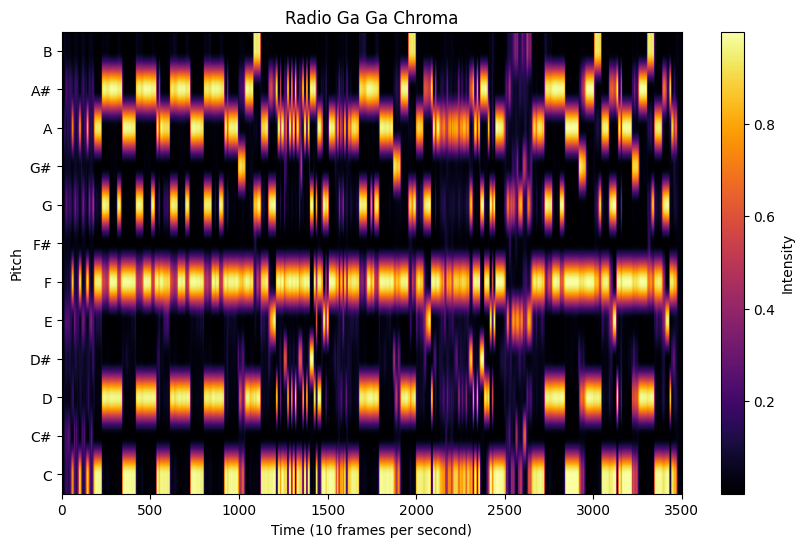

In [9]:
fig = plt.figure(figsize=(10, 6))
plt.imshow(chroma.T, aspect='auto', origin='lower', cmap='inferno')
plt.title(chosentitle + ' Chroma')
plt.xlabel('Time (10 frames per second)')
plt.yticks(ticks=np.arange(12), labels=['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B'])
plt.ylabel('Pitch')
plt.colorbar(label='Intensity')
plt.savefig(plots_dir + chosentitle + '_chroma.png')
plt.show()

### Plot SSM

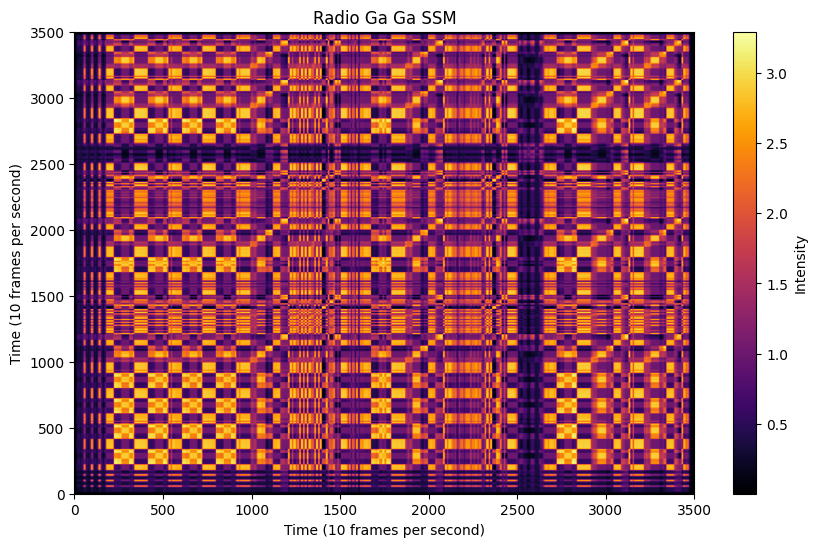

In [10]:
fig = plt.figure(figsize=(10, 6))
plt.imshow(ssm, aspect='auto', origin='lower', cmap='inferno')
plt.title(chosentitle + ' SSM')
plt.xlabel('Time (10 frames per second)')
plt.ylabel('Time (10 frames per second)')
plt.colorbar(label='Intensity')
plt.savefig(plots_dir + chosentitle + '_ssm.png')
plt.show()

### Plot Histogram

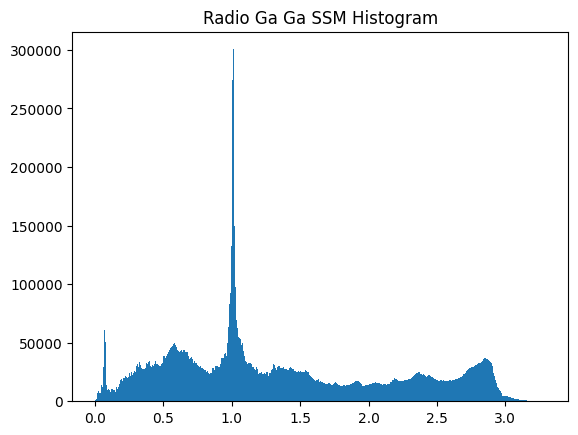

<Figure size 640x480 with 0 Axes>

In [11]:
plt.bar(limits[:-1], counting, width=np.diff(limits), align="edge")
plt.title(chosentitle + ' SSM Histogram')
plt.savefig(plots_dir + chosentitle + '_histogram.png')
plt.show()
plt.clf()

### Difference Histogram

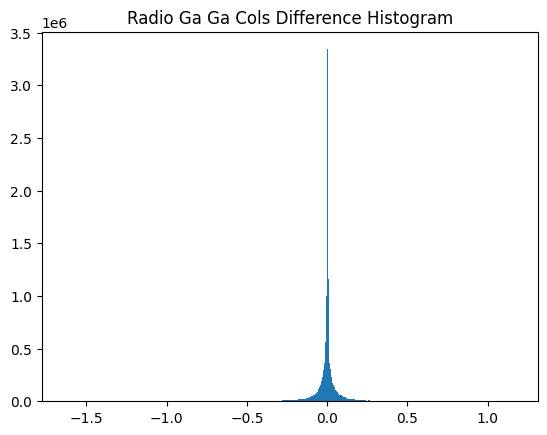

<Figure size 640x480 with 0 Axes>

In [12]:
plt.bar(difference_cols_limits[:-1], difference_cols_counting, width=np.diff(limits), align="edge")

plt.title(chosentitle + ' Cols Difference Histogram')
plt.savefig(plots_dir + chosentitle + '_diff_histogram.png')
plt.show()
plt.clf()

## Visualize Column Hist


In [ ]:
for col in range(10,15):
    unique_col = difference_cols[:,col]
    col_counts, col_limits = np.histogram(unique_col, bins=500)

    plt.bar(col_limits[:-1] , col_counts , width=np.diff(limits), align="edge")
    plt.savefig(f'diff_{col}_hist')
    plt.clf()


<Figure size 640x480 with 0 Axes>